In [1]:
!pip install scikit-learn imbalanced-learn xgboost
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install imbalanced-learn scikit-learn pandas numpy matplotlib seaborn

Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
import pyarrow.orc as orc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')

In [3]:
# 1. Define the file path
path = r'spend_analysis_final.orc'

# 2. Load the file using PyArrow first (more efficient)
orc_file = orc.ORCFile(path)
table = orc_file.read()

# 3. Convert to Pandas with "self_destruct"
# self_destruct=True: Frees the Arrow memory AS it creates the Pandas DF
# split_blocks=True: Allows data to be scattered in RAM (doesn't need one giant 4GB block)
df = table.to_pandas(split_blocks=True, self_destruct=True)

print(df.head())
print(df.info()) # Check memory usage

     txn_date  year  month   age_group    income_tier user_gender  card_brand  \
0  2008-05-11  2008      5  Millennial  Middle_Income      Female  Mastercard   
1  2007-08-27  2007      8  Millennial  Middle_Income      Female  Mastercard   
2  2009-02-22  2009      2  Millennial  Middle_Income      Female  Mastercard   
3  2007-09-18  2007      9  Millennial  Middle_Income      Female  Mastercard   
4  2009-03-11  2009      3  Millennial  Middle_Income      Female  Mastercard   

  card_type spend_location_type   mcc total_spend_amount  transaction_count  \
0     Debit      Online/Unknown  4121             111.20                  5   
1     Debit      Online/Unknown  7801              84.09                  1   
2     Debit      Online/Unknown  4121              95.42                  6   
3     Debit     Travel_Domestic  7802             106.66                  1   
4     Debit      Online/Unknown  4814             139.15                  1   

  avg_ticket_size fraud_spend_amount m

## Model Evaluation Metrics

🔄 Transforming Transaction Data...
✅ User Profiles Created: 500 Users
Category    Dining  Groceries    Retail  Transport    Travel  Utilities
user_id                                                                
0         0.081516   0.133905  0.095890   0.388252  0.105486   0.194951
1         0.230136   0.087321  0.428562   0.022428  0.216546   0.015007
2         0.182450   0.073803  0.123299   0.332123  0.116416   0.171910

🧩 Running Lifestyle Segmentation (K-Means)...
   Silhouette Score: 0.202 (Higher is better)

--- Lifestyle Cluster Profiles (Avg Wallet Share) ---
Category      Dining   Groceries      Retail   Transport      Travel  \
Cluster                                                                
0          94.337000  127.900364  402.703578   85.346000  189.856982   
1          89.096165  133.132373  188.287271  274.488184  197.605823   
2         281.871307  102.085429  182.146266   88.619378  195.432856   
3          86.503739  124.650862  188.547812   83.846510  384.

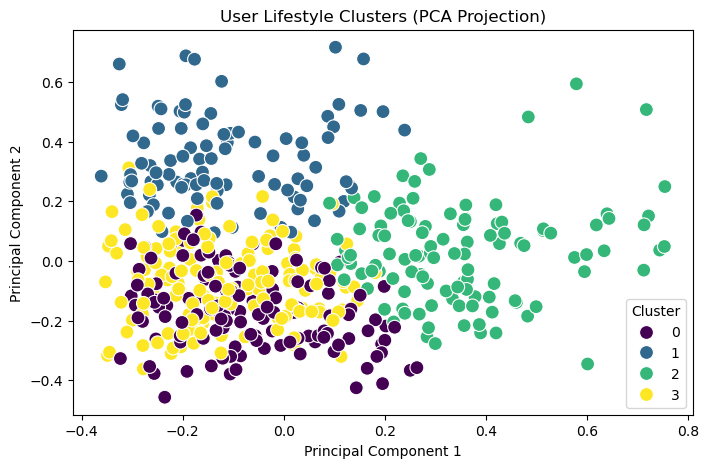


🎯 Training Merchant Affinity Model...

--- Affinity Model Performance ---
              precision    recall  f1-score   support

    Standard       0.85      0.95      0.90        73
  High Value       0.79      0.56      0.65        27

    accuracy                           0.84       100
   macro avg       0.82      0.75      0.77       100
weighted avg       0.84      0.84      0.83       100


--- Top Predictors of Dining Affinity ---
Category
Travel       0.236272
Retail       0.217727
Transport    0.191247
Utilities    0.184546
Groceries    0.170208
dtype: float64

✅ Final Data Ready for Export:
Category  Total_Spend                      Lifestyle_Label  \
user_id                                                      
0         1013.854838  The Homebody (High Grocery/Utility)   
1          868.264378     The Traveler (High Travel Share)   
2          701.132872  The Homebody (High Grocery/Utility)   
3          769.939903            The Shopper (High Retail)   
4         1244.20

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, mean_absolute_error, classification_report

# ==========================================
# 1. Mock Data Generation (Transaction Level)
# ==========================================
# We simulate raw transactions to demonstrate the pivot logic
np.random.seed(42)
n_txns = 10000
n_users = 500

data = {
    'user_id': np.random.randint(0, n_users, n_txns),
    'amount': np.random.exponential(50, n_txns),
    'mcc': np.random.choice([
        3000, 3500, # Travel (Airlines, Hotels)
        5411, 5812, # Food (Groceries, Restaurants)
        5541, 4814, # Utilities (Gas, Telecom)
        5311, 5999  # Retail (Dept Stores, Misc)
    ], n_txns),
    'txn_date': pd.date_range(start='2024-01-01', periods=n_txns).tolist()
}
df = pd.DataFrame(data)

# ==========================================
# 2. MCC Mapping & Pivot Logic (The Core)
# ==========================================
print("🔄 Transforming Transaction Data...")

def map_mcc(code):
    if 3000 <= code <= 3999: return 'Travel'
    if 5400 <= code <= 5499: return 'Groceries'
    if 5800 <= code <= 5899: return 'Dining'
    if 5500 <= code <= 5599: return 'Transport'
    if 4800 <= code <= 4999: return 'Utilities'
    return 'Retail'

df['Category'] = df['mcc'].apply(map_mcc)

# Pivot: Rows = Users, Cols = Categories, Values = Total Amount
user_profile = df.pivot_table(
    index='user_id', 
    columns='Category', 
    values='amount', 
    aggfunc='sum', 
    fill_value=0
)

# Feature Engineering: Wallet Share (%)
# We care about % of spend, not just raw totals, to find "Lifestyle"
user_profile['Total_Spend'] = user_profile.sum(axis=1)
wallet_share = user_profile.div(user_profile['Total_Spend'], axis=0).iloc[:, :-1] # Drop Total col

print(f"✅ User Profiles Created: {user_profile.shape[0]} Users")
print(wallet_share.head(3))

# ==========================================
# 3. Model A: Lifestyle Segmentation (Unsupervised)
# ==========================================
print("\n🧩 Running Lifestyle Segmentation (K-Means)...")

# Scale features (Percent data is already 0-1, but scaling helps KMeans)
scaler = MinMaxScaler()
X_cluster = scaler.fit_transform(wallet_share)

# Fit K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_profile['Cluster'] = kmeans.fit_predict(X_cluster)

# Evaluate
sil_score = silhouette_score(X_cluster, user_profile['Cluster'])
print(f"   Silhouette Score: {sil_score:.3f} (Higher is better)")

# Interpret Clusters
cluster_summary = user_profile.groupby('Cluster')[wallet_share.columns].mean()
print("\n--- Lifestyle Cluster Profiles (Avg Wallet Share) ---")
print(cluster_summary)

# Visualize Clusters (PCA)
pca = PCA(n_components=2)
coords = pca.fit_transform(X_cluster)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=user_profile['Cluster'], palette='viridis', s=100)
plt.title('User Lifestyle Clusters (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# ==========================================
# 4. Model B: Merchant Affinity Prediction (Supervised)
# ==========================================
print("\n🎯 Training Merchant Affinity Model...")

# Goal: Predict if a user is a "High Value Diner" (Top 33% of Dining spenders)
# This helps us target them for Dining Rewards Cards.

dining_threshold = user_profile['Dining'].quantile(0.67)
user_profile['Is_High_Value_Diner'] = (user_profile['Dining'] > dining_threshold).astype(int)

# Features: All OTHER spending habits (excluding Dining itself to prevent leakage)
X_affinity = wallet_share.drop(columns=['Dining'])
y_affinity = user_profile['Is_High_Value_Diner']

X_train, X_test, y_train, y_test = train_test_split(X_affinity, y_affinity, test_size=0.2, random_state=42)

# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("\n--- Affinity Model Performance ---")
print(classification_report(y_test, y_pred, target_names=['Standard', 'High Value']))

# Feature Importance
importances = pd.Series(clf.feature_importances_, index=X_affinity.columns)
print("\n--- Top Predictors of Dining Affinity ---")
print(importances.sort_values(ascending=False))

# ==========================================
# 5. Business Output
# ==========================================
# We map the cluster numbers to business names for the final report
cluster_names = {
    0: 'The Traveler (High Travel Share)',
    1: 'The Homebody (High Grocery/Utility)',
    2: 'The Socialite (High Dining)',
    3: 'The Shopper (High Retail)'
    # Note: These names are examples; check the 'Cluster Profiles' printout to name them accurately
}
user_profile['Lifestyle_Label'] = user_profile['Cluster'].map(cluster_names).fillna('Mixed')

print("\n✅ Final Data Ready for Export:")
print(user_profile[['Total_Spend', 'Lifestyle_Label', 'Is_High_Value_Diner']].head())

In [14]:
# Join Cluster labels to the Wallet Share (Percentage) Dataframe
wallet_share['Cluster'] = user_profile['Cluster']

# Group by Cluster to see the AVERAGE PERCENTAGE spend
true_lifestyle_profile = wallet_share.groupby('Cluster').mean()

print("\n📊 CORRECTED Lifestyle Profiles (Values are % of Wallet):")
# Multiply by 100 for readability (e.g., 0.45 -> 45%)
print((true_lifestyle_profile * 100).round(1).astype(str) + '%')

# Now you can name them accurately:
# If Cluster 0 has 'Travel': 55%, name it "The Jetsetter"


📊 CORRECTED Lifestyle Profiles (Values are % of Wallet):
Category Dining Groceries Retail Transport Travel Utilities
Cluster                                                    
0          9.2%     12.8%  40.0%      8.2%  18.3%     11.4%
1          9.0%     13.8%  18.6%     28.0%  18.9%     11.6%
2         29.6%     10.6%  18.4%      9.6%  20.0%     11.9%
3          8.1%     12.4%  18.5%      8.1%  38.6%     14.3%


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Re-train with 'class_weight="balanced"'
# This penalizes missing the "High Value" users more
clf_balanced = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf_balanced.fit(X_train, y_train)

y_pred_balanced = clf_balanced.predict(X_test)

print("\n🚀 Improved Affinity Model (Balanced):")
print(classification_report(y_test, y_pred_balanced, target_names=['Standard', 'High Value']))


🚀 Improved Affinity Model (Balanced):
              precision    recall  f1-score   support

    Standard       0.86      0.95      0.90        73
  High Value       0.80      0.59      0.68        27

    accuracy                           0.85       100
   macro avg       0.83      0.77      0.79       100
weighted avg       0.85      0.85      0.84       100

